In [1]:
import numpy as np
import os 
import torch
import matplotlib.pyplot as plt

### Generate Data

torch.Size([2000, 2])


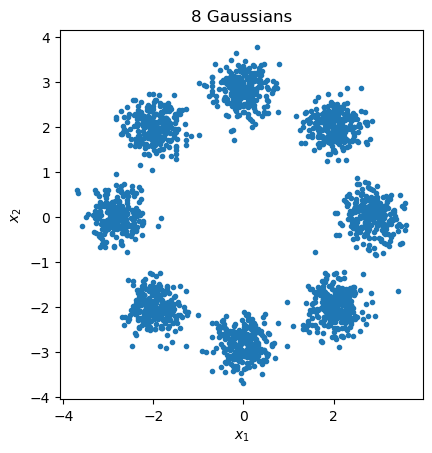

In [2]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

### Density vs. Energy

The density $p(x)$ can also be rephrased in the context of an energy $f(x)$ using the Gibbs-Boltzmann distribution from statistical physics
$$
    p(x) = \frac{1}{\mathcal{Z}}e^{-\frac{f(x)}{kT}},
$$
where $x \in \mathbb{R}^d$ is a state or configuration, $f(x)$ is the energy associated with that state, $k$ is the Boltzmann constant, 
$T$ is the temperature, and $Z$ is the partition function.
By using this connection, we can rewrite the probability distribution in terms of an energy function:
$$
    f(x) = -\log{p(x)} + const.
$$

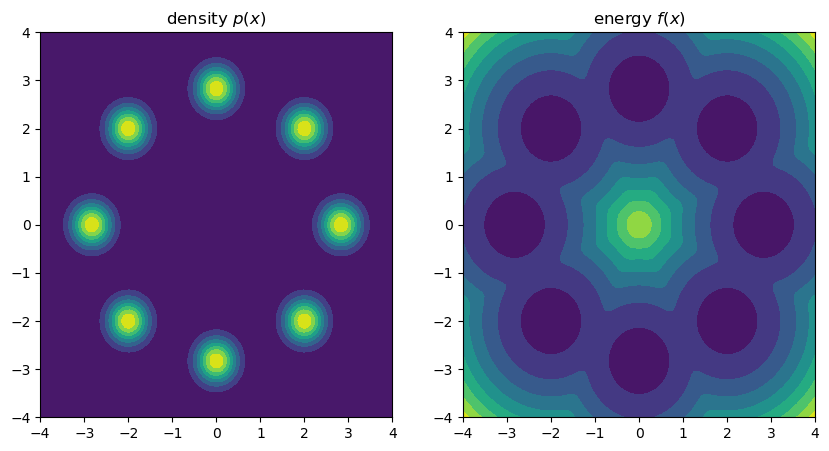

In [3]:
# energy vs. density
def p_simple(x):
    d, k = mus.shape
    n = x.shape[0]
    
    fact = 1. / 8.*((2 * np.pi) ** (d / 2) * torch.sqrt(torch.linalg.det(sig)))  # shape (k,)   
    tmp = x.unsqueeze(2) - mus.unsqueeze(0)  # (n, d, k)
    inv_sig = torch.linalg.inv(sig)  # (d, d)
    exp_tmp = torch.einsum('di,nik->ndk', inv_sig, tmp)
    exp_term = -0.5*torch.einsum('nik,nik->nk', tmp, exp_tmp)
    
    # Each component's pdf
    component_pdfs = fact * torch.exp(exp_term)  # (n, k)
    return torch.sum(component_pdfs, dim=1)  # (n,)

xx, yy = torch.meshgrid(torch.linspace(-4.,4.,100), torch.linspace(-4.,4,100))
positions = torch.vstack([xx.ravel(), yy.ravel()])
zz = p_simple(positions.T).reshape(xx.shape)

# plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].contourf(xx.numpy(),yy.numpy(),zz.numpy()), ax[0].set_title('density $p(x)$')
ax[1].contourf(xx.numpy(),yy.numpy(),-torch.log(zz).numpy()), ax[1].set_title('energy $f(x)$')
plt.show()


### Wiener process

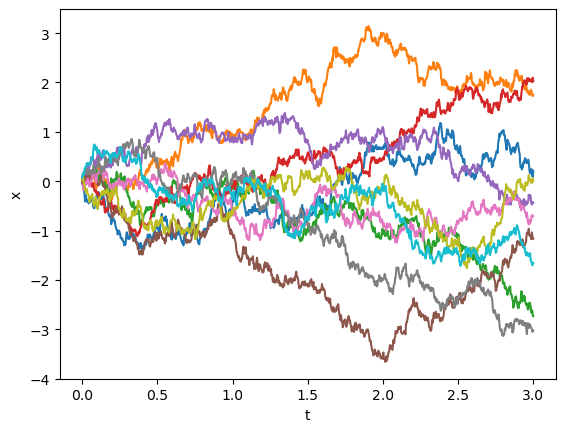

In [5]:
n_samples = 10
x_1d = torch.zeros((n_samples))

steps = 1000
t_all = torch.linspace(0.,3.,steps=steps)
dt = t_all[1]-t_all[0]

x_1d_traj = []
for t in t_all:
    x_1d = x_1d + np.sqrt(dt)*torch.randn_like(x_1d)
    x_1d_traj.append(x_1d)

plt.figure()
plt.plot(t_all,np.stack(x_1d_traj))
plt.xlabel('t'), plt.ylabel('x')
plt.show()

### Langevin Sampling

In [6]:
# Langevin sampling parameters
max_it = 100000
n_samples = 10000
tau = 1e-2

# Initialize with random state z0
z0 = torch.randn(n_samples, 2)
z_traj = []

for it in range(max_it):  
    z_traj.append(z0.detach())

    z0.requires_grad_(True)
    res = -torch.log(p_simple(z0) + 1e-10)  # Add small constant to avoid log(0)
    dlogp = torch.autograd.grad(res.sum(), z0)[0]
    z0 = z0.detach()  # Detach tensor to stop tracking gradients

    # Langevin dynamics update
    z = z0 - tau * dlogp + np.sqrt(2 * tau) * torch.randn(n_samples, 2)
    z0 = z.clone()  # Update z0 for the next iteration

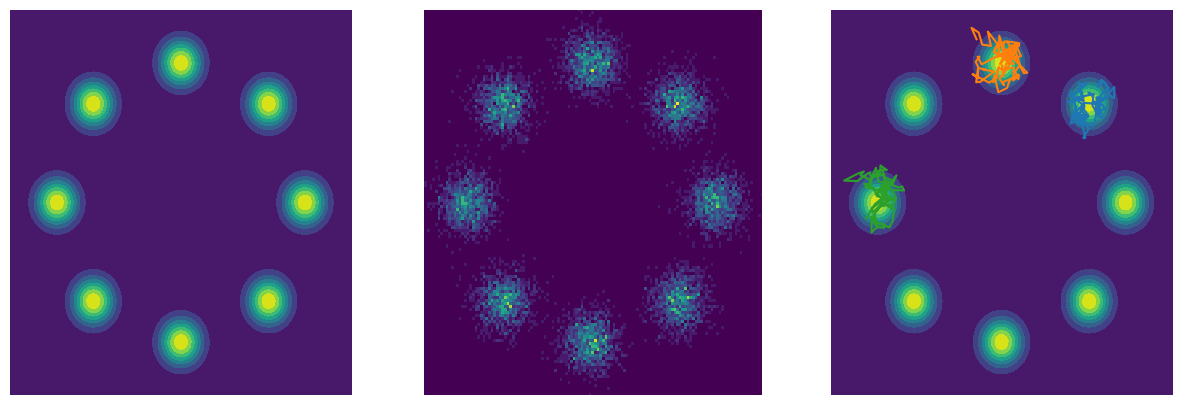

In [7]:
# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# True density plot
xx, yy = np.meshgrid(np.linspace(-4, 4, 128), np.linspace(-4, 4, 128))
zz = p_simple(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
ax[0].contourf(xx, yy, zz.detach().numpy())

# ULA samples histogram
ax[1].hist2d(z[:, 0].detach().numpy(), z[:, 1].detach().numpy(), bins=128, density=True)

# ULA selected trajectories
l = 100
s1 = 60000
s2 = 50000
traj_stacked = torch.stack((z_traj)).detach().permute(1,0,2).reshape(-1,2)
ax[2].contourf(xx, yy, zz.detach().numpy())
ax[2].plot(traj_stacked[s1:s1+l,0],traj_stacked[s1:s1+l,1],'-')
ax[2].plot(traj_stacked[-s2:-s2+l,0],traj_stacked[-s2:-s2+l,1],'-')
ax[2].plot(traj_stacked[-l::,0],traj_stacked[-l::,1],'-')
#ax[1].set_xticks([]), ax[1].set_yticks([])
offs = 0.1
for a in ax:
    a.set_xlim([-4.+offs, 4.-offs])
    a.set_ylim([-4.+offs, 4.-offs])
    a.axis('off')

plt.savefig(os.getcwd() + '/out/langevin.png',bbox_inches='tight')
plt.show()